In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from IPython.display import display
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv


# Custom functions

# Read data

In [2]:
# read data from csv
data_df = pd.read_csv('/kaggle/input/home-data-for-ml-course/train.csv',
                     keep_default_na= False)

display(data_df.head())
data_df.isnull().sum().to_csv("count_na.csv")
data_df.dtypes.to_csv("data_types.csv")
display(data_df.describe())

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65,8450,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,2,2008,WD,Normal,208500
1,2,20,RL,80,9600,Pave,NA,Reg,Lvl,AllPub,...,0,NA,NA,NA,0,5,2007,WD,Normal,181500
2,3,60,RL,68,11250,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,9,2008,WD,Normal,223500
3,4,70,RL,60,9550,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84,14260,Pave,NA,IR1,Lvl,AllPub,...,0,NA,NA,NA,0,12,2008,WD,Normal,250000


,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,10516.828082,6.099315,5.575342,1971.267808,1984.865753,443.639726,46.549315,567.240411,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,9981.264932,1.382997,1.112799,30.202904,20.645407,456.098091,161.319273,441.866955,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,223.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,383.500000,0.000000,477.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,712.250000,0.000000,808.000000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,5644.000000,1474.000000,2336.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


# Preprocess data

In [3]:
data_processed = data_df.copy()

# identify correct data type for each column
column_types_dict = {
        'Id': 'id',
        'MSSubClass': 'category',
        'MSZoning': 'category',
        'LotFrontage': 'numeric',
        'LotArea': 'numeric',
        'Street': 'category',
        'Alley': 'category',
        'LotShape': 'ordinal',
        'LandContour': 'category',
        'Utilities': 'ordinal',
        'LotConfig': 'category',
        'LandSlope': 'ordinal',
        'Neighborhood': 'category',
        'Condition1': 'category',
        'Condition2': 'category',
        'BldgType': 'category',
        'HouseStyle': 'category',
        'OverallQual': 'numeric',
        'OverallCond': 'numeric',
        'YearBuilt': 'numeric',
        'YearRemodAdd': 'numeric',
        'RoofStyle': 'category',
        'RoofMatl': 'category',
        'Exterior1st': 'category',
        'Exterior2nd': 'category',
        'MasVnrType': 'category',
        'MasVnrArea': 'numeric',
        'ExterQual': 'ordinal',
        'ExterCond': 'ordinal',
        'Foundation': 'category',
        'BsmtQual': 'ordinal',
        'BsmtCond': 'ordinal',
        'BsmtExposure': 'ordinal',
        'BsmtFinType1': 'ordinal',
        'BsmtFinSF1': 'numeric',
        'BsmtFinType2': 'ordinal',
        'BsmtFinSF2': 'numeric',
        'BsmtUnfSF': 'numeric',
        'TotalBsmtSF': 'numeric',
        'Heating': 'category',
        'HeatingQC': 'ordinal',
        'CentralAir': 'category',
        'Electrical': 'category',
        '1stFlrSF': 'numeric',
        '2ndFlrSF': 'numeric',
        'LowQualFinSF': 'numeric',
        'GrLivArea': 'numeric',
        'BsmtFullBath': 'numeric',
        'BsmtHalfBath': 'numeric',
        'FullBath': 'numeric',
        'HalfBath': 'numeric',
        'BedroomAbvGr': 'numeric',
        'KitchenAbvGr': 'numeric',
        'KitchenQual': 'ordinal',
        'TotRmsAbvGrd': 'numeric',
        'Functional': 'ordinal',
        'Fireplaces': 'numeric',
        'FireplaceQu': 'ordinal',
        'GarageType': 'category',
        'GarageYrBlt': 'numeric',
        'GarageFinish': 'ordinal',
        'GarageCars': 'numeric',
        'GarageArea': 'numeric',
        'GarageQual': 'ordinal',
        'GarageCond': 'ordinal',
        'PavedDrive': 'ordinal',
        'WoodDeckSF': 'numeric',
        'OpenPorchSF': 'numeric',
        'EnclosedPorch': 'numeric',
        '3SsnPorch': 'numeric',
        'ScreenPorch': 'numeric',
        'PoolArea': 'numeric',
        'PoolQC': 'ordinal',
        'Fence': 'ordinal',
        'MiscFeature': 'category',
        'MiscVal': 'numeric',
        'MoSold': 'numeric',
        'YrSold': 'numeric',
        'SaleType': 'category',
        'SaleCondition': 'category',
        'SalePrice': 'numeric',
}

## bimary columns for categories

In [4]:
# create binary columns from category columns
def create_binary_columns(
    column_types_dict,
    df,
    encoder = None,
):
    category_col = [col for col, col_type in column_types_dict.items() if column_types_dict[col] == 'category']

    if encoder == None:
        one_hot_enc = OneHotEncoder(handle_unknown='ignore')
        one_hot_enc.fit(df[category_col])
    else:
        one_hot_enc = encoder
        
    binary_df = one_hot_enc.transform(data_df[category_col]).toarray()
    binary_columns = one_hot_enc.get_feature_names_out(category_col)
    binary_df = pd.DataFrame(binary_df, columns = binary_columns)
    
    # merge original data with binary columns
    df = df.drop(columns = category_col)
    df = pd.concat([df, binary_df], axis = 1)

    return one_hot_enc, df

one_hot_encoder, data_processed = create_binary_columns(column_types_dict, data_processed)

## numeric columns

In [5]:
# process numeric columns
def process_numeric_columns(
    column_types_dict,
    df,
    imputers = {}
):
    num_col = [col for col, col_type in column_types_dict.items() if column_types_dict[col] == 'numeric']
    
    for col in num_col:
        if (df[col].dtype != float) and (df[col].dtype != int):
            df[col] = pd.to_numeric(df[col], errors = 'coerce')

            # fill in missing values
            if col == 'MasVnrArea':
                if col in imputers.keys():
                    imputer = imputers[col]
                else:
                    imputer = SimpleImputer(
                        missing_values=np.nan,
                        strategy='constant',
                        fill_value = 0.0
                    )
                    imputer.fit(np.array(df[col]).reshape(-1,1))
                df[col] = imputer.transform(np.array(df[col]).reshape(-1,1))
            else:
                if col in imputers.keys():
                    imputer = imputers[col]
                else:
                    imputer = SimpleImputer(
                        missing_values=np.nan,
                        strategy='mean',
                    )
                    imputer.fit(np.array(df[col]).reshape(-1,1))
                df[col] = imputer.transform(np.array(df[col]).reshape(-1,1))
            
    return df
    
data_processed = process_numeric_columns(column_types_dict, data_processed)

## ordinal columns

In [6]:
# process ordinal columns
def process_ordinal_columns(
    column_types_dict,
    df,
    ordinal_encoders = {},
):
    ordinal_col = [col for col, col_type in column_types_dict.items() if column_types_dict[col] == 'ordinal']

    ordinal_translation = {
        "LotShape": ['Reg', 'IR1', 'IR2', 'IR3'],
        'Utilities': ['AllPub', 'NoSewr', 'NoSeWa', 'ELO'],
        'LandSlope': ['Gtl', 'Mod', 'Sev'],
        'ExterQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
        'ExterCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
        'BsmtQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
        'BsmtCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
        'BsmtExposure': ['Gd', 'Av', 'Mn', 'No', 'NA'],
        'BsmtFinType1': ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
        'BsmtFinType2': ['GLQ', 'ALQ', 'BLQ', 'Rec', 'LwQ', 'Unf', 'NA'],
        'HeatingQC': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
        'KitchenQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po'],
        'Functional': ['Typ', 'Min1', 'Min2', 'Mod', 'Maj1', 'Maj2', 'Sev', 'Sal'],
        'FireplaceQu': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
        'GarageFinish': ['Fin', 'RFn', 'Unf', 'NA'],
        'GarageQual': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
        'GarageCond': ['Ex', 'Gd', 'TA', 'Fa', 'Po', 'NA'],
        'PavedDrive': ['Y', 'P', 'N'],
        'PoolQC': ['Ex', 'Gd', 'TA', 'Fa', 'NA'],
        'Fence': ['GdPrv', 'MnPrv', 'GdWo', 'MnWw', 'NA'],
    }

    for col in ordinal_col:
        if col in ordinal_encoders.keys():
            encoder = ordinal_encoders[col]
        else:
            encoder = OrdinalEncoder(
                categories = [ordinal_translation[col]],
                handle_unknown = "use_encoded_value",
                unknown_value = np.nan
            ).fit(
                np.array(df[col]).reshape(-1,1),
            )
            ordinal_encoders[col] = encoder
        df[col] = encoder.transform(np.array(df[col]).reshape(-1,1))
            
    return ordinal_encoders, df
    
ordinal_encoders, data_processed = process_ordinal_columns(column_types_dict, data_processed)

In [7]:
display(data_processed.head())
display(data_processed.describe())
data_processed.isnull().sum().to_csv('processed_data_count_na.csv')
data_processed.to_csv('processed_data.csv')
data_processed.dtypes.to_csv("processed_data_types.csv")

,Id,LotFrontage,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,65.0,8450,0.0,0.0,0.0,7,5,2003,2003,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,80.0,9600,0.0,0.0,0.0,6,8,1976,1976,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,68.0,11250,1.0,0.0,0.0,7,5,2001,2002,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,60.0,9550,1.0,0.0,0.0,7,5,1915,1970,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0
4,5,84.0,14260,1.0,0.0,0.0,8,5,2000,2000,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0


,Id,LotFrontage,LotArea,LotShape,Utilities,LandSlope,OverallQual,OverallCond,YearBuilt,YearRemodAdd,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,70.049958,10516.828082,0.408219,0.001370,0.062329,6.099315,5.575342,1971.267808,1984.865753,...,0.003425,0.083562,0.002055,0.867808,0.069178,0.002740,0.008219,0.013699,0.820548,0.085616
std,421.610009,22.024023,9981.264932,0.582296,0.052342,0.276232,1.382997,1.112799,30.202904,20.645407,...,0.058440,0.276824,0.045299,0.338815,0.253844,0.052289,0.090317,0.116277,0.383862,0.279893
min,1.000000,21.000000,1300.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1872.000000,1950.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,365.750000,60.000000,7553.500000,0.000000,0.000000,0.000000,5.000000,5.000000,1954.000000,1967.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,730.500000,70.049958,9478.500000,0.000000,0.000000,0.000000,6.000000,5.000000,1973.000000,1994.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,1095.250000,79.000000,11601.500000,1.000000,0.000000,0.000000,7.000000,6.000000,2000.000000,2004.000000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,1460.000000,313.000000,215245.000000,3.000000,2.000000,2.000000,10.000000,9.000000,2010.000000,2010.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Exploratory Analysis

## correlations

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


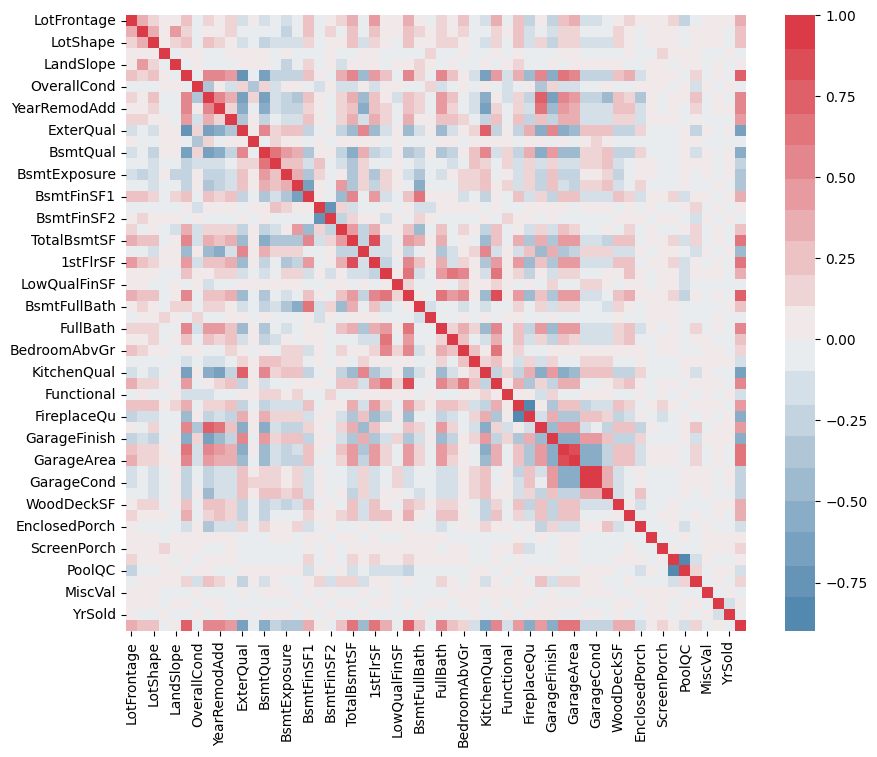

In [17]:
num_ordinal_col = [
    col for col, col_type in column_types_dict.items()\
    if column_types_dict[col] in ['numeric', 'ordinal']
]

num_df = data_processed[num_ordinal_col]

plt.figure(figsize=(10,8))
sns.heatmap(
    num_df.corr(),
    cmap = sns.diverging_palette(240, 10, n = 20),
    center = 0
)
plt.show()

## distribution of numeric values

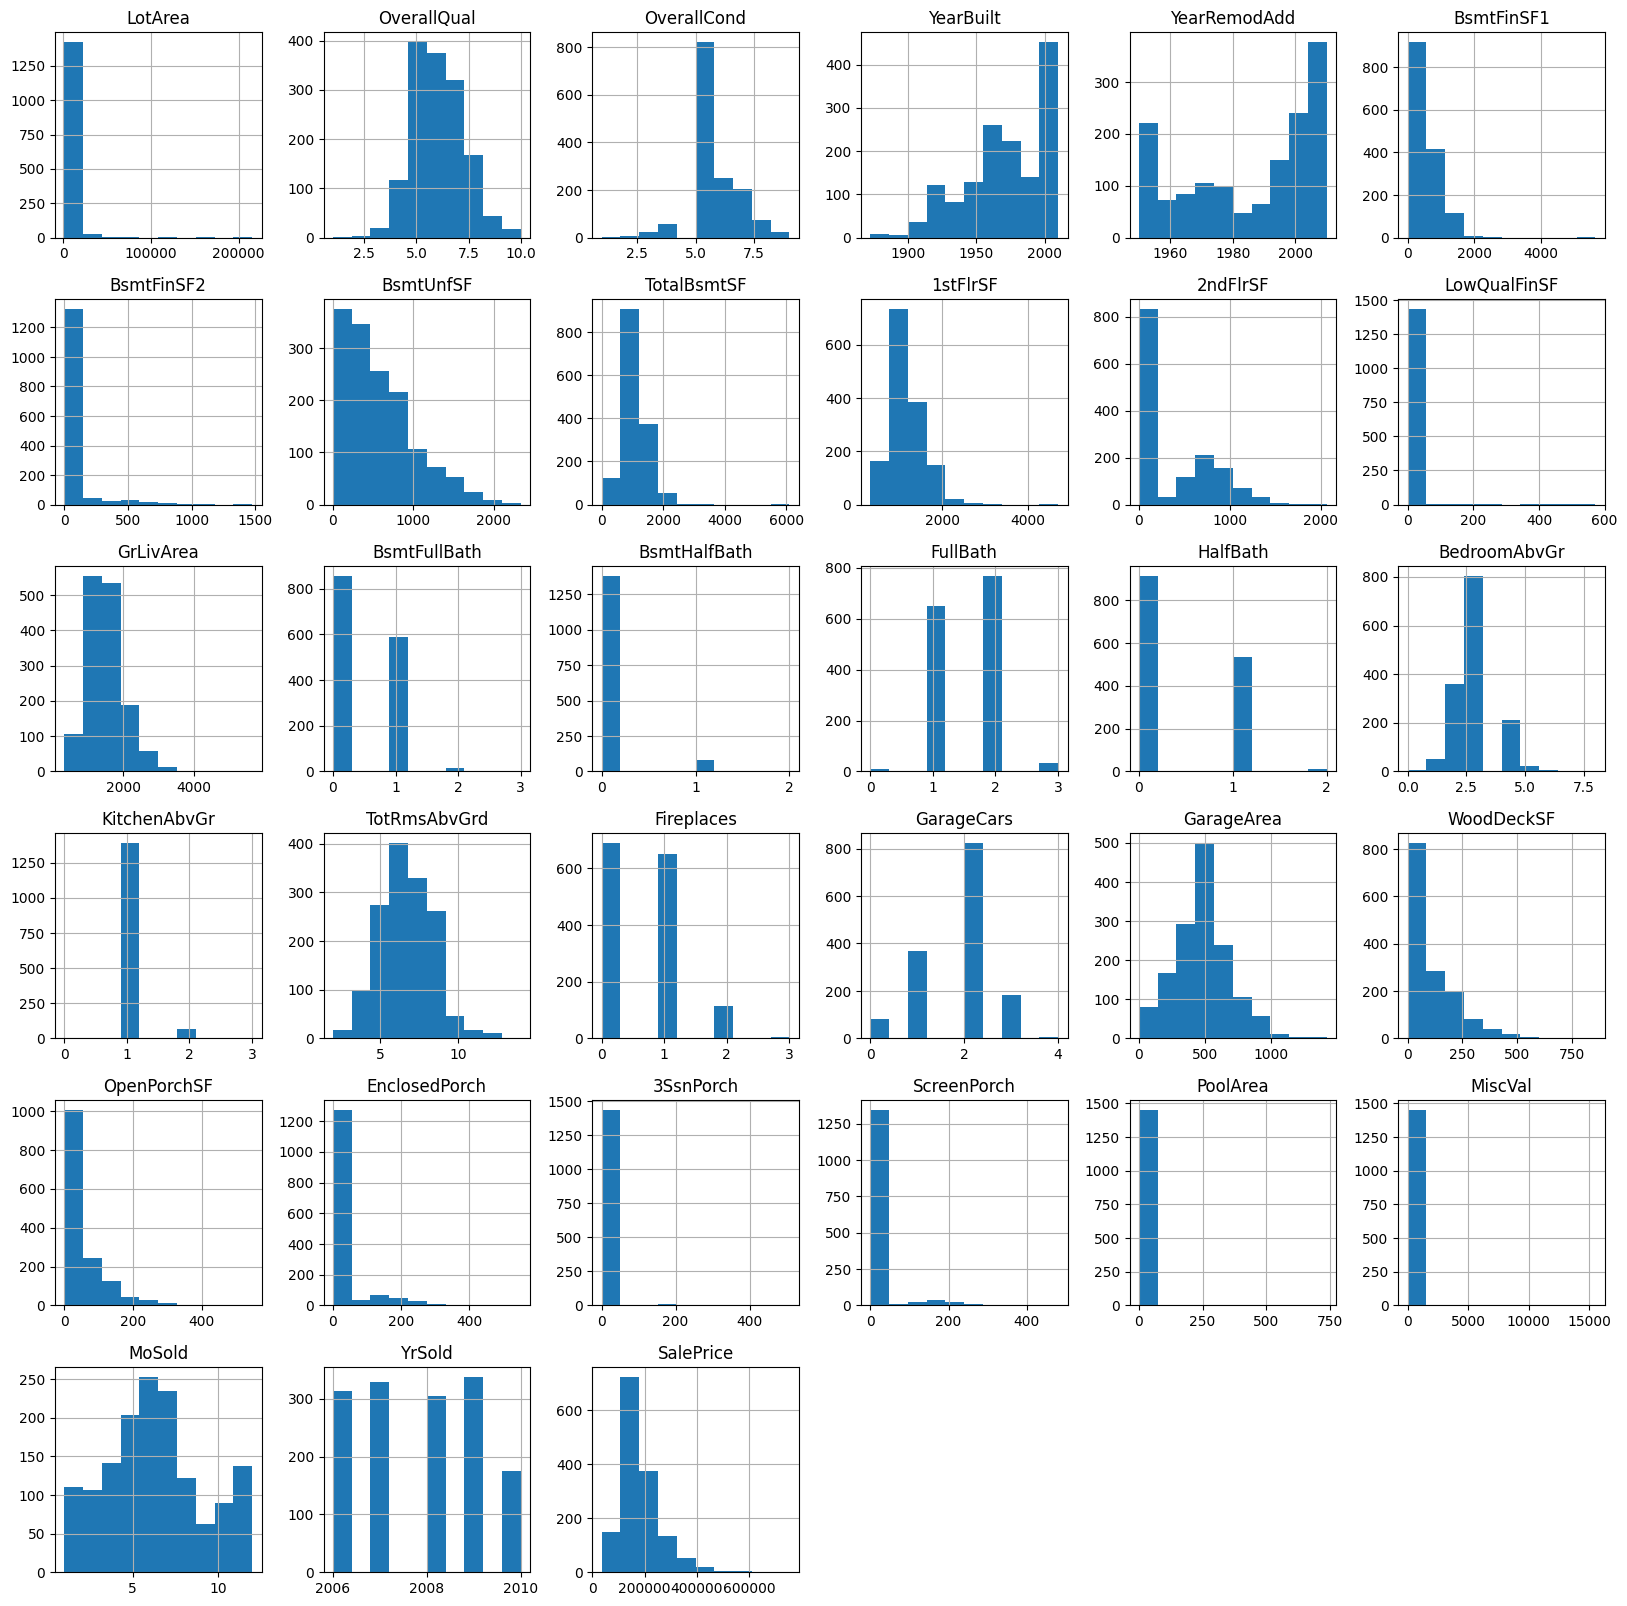

In [19]:
num_ordinal_df = data_df[num_ordinal_col]
num_ordinal_df.hist(figsize=(20,20))
plt.show()

## distribution of sales prices by category

In [ ]:
"""cat_col = [
    col for col, col_type in column_types_dict.items()\
    if column_types_dict[col] in ['category']
]"""